# Varifold distances between subjects


Before, we looked at [how varifold distances change across derivatives](./varifold_pairwise_distances_derivative.ipynb).

Here, we check how varifold distances across subjects compare, for a fixed derivative.

In [1]:
import numpy as np
import polpo.preprocessing.dict as ppdict
import polpo.utils as putils
from matplotlib import pyplot as plt
from polpo.mesh.surface import PvSurface
from polpo.mesh.varifold.tuning import SigmaFromLengths
from polpo.preprocessing.load.pregnancy.jacobs import (
    MeshLoader,
    get_subject_ids,
)
from polpo.preprocessing.mesh.registration import RigidAlignment

[KeOps] Warning : CUDA was detected, but driver API could not be initialized. Switching to CPU only.


In [2]:
STRUCT = "L_Hipp"
SUBJECT_IDS = get_subject_ids(sort=True)

SUBSAMPLE = None

In [3]:
mesh_loader = (
    MeshLoader(
        subject_subset=SUBJECT_IDS,
        struct_subset=[STRUCT],
        derivative="enigma",
        as_mesh=True,
    )
    + ppdict.ExtractUniqueKey(nested=True)
    + ppdict.DictMap(ppdict.Subsample(SUBSAMPLE))
)

# subject, session
raw_meshes = mesh_loader()

In [4]:
align_pipe = RigidAlignment(
    target=ppdict.ExtractRandomKey()(putils.get_first(raw_meshes)),
    known_correspondences=True,
)

meshes = (ppdict.DictMap(align_pipe + ppdict.DictMap(PvSurface)))(raw_meshes)

We select the varifold kernel [using characteristic lengths](https://geometric-intelligence.github.io/polpo/_generated/notebooks/how_to/varifold_kernel_charlen.html).

In [5]:
sigma_search = SigmaFromLengths(
    ratio_charlen_mesh=2.0,
    ratio_charlen=0.25,
)

In [6]:
# one mesh per subject
mesh_per_subject = (
    ppdict.DictMap(ppdict.ExtractRandomKey()) + ppdict.DictToValuesList()
)(meshes)

sigma_search.fit(mesh_per_subject)

metric = sigma_search.optimal_metric_

sigma_search.sigma_

np.float64(6.362337830107553)

In [7]:
meshes_flat = ppdict.UnnestDict(sep="-")(meshes)

In [8]:
dists = putils.pairwise_dists(list(meshes_flat.values()), metric)

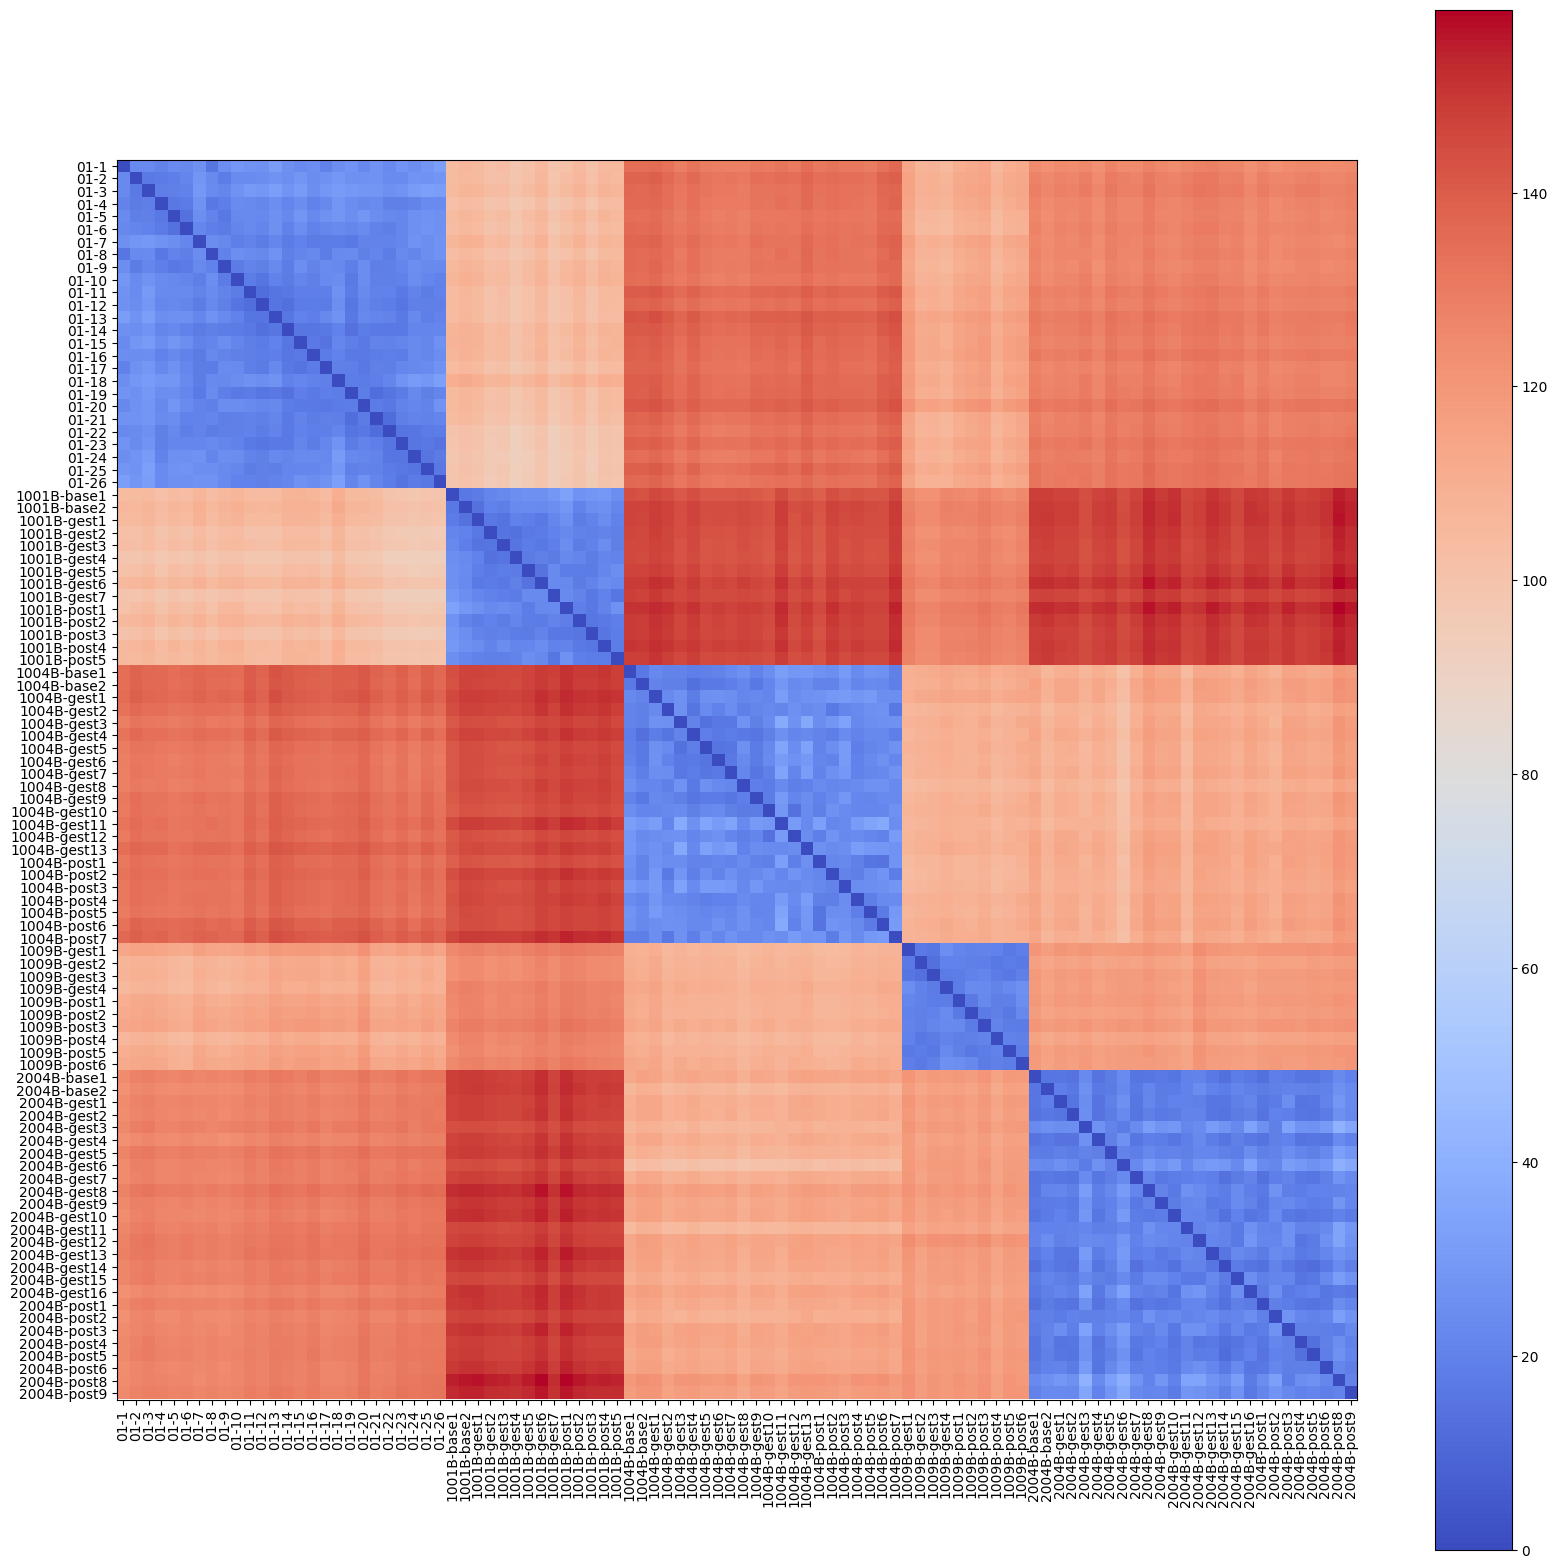

In [12]:
fig, ax = plt.subplots(figsize=(20, 20))

im = ax.imshow(dists, cmap="coolwarm")

plt.colorbar(im)

ax.set_xticks(range(len(meshes_flat)))
ax.set_xticklabels(meshes_flat.keys(), rotation=90)

ax.set_yticks(range(len(meshes_flat)))
ax.set_yticklabels(meshes_flat.keys())
plt.tick_params(axis="both", labelsize=10)

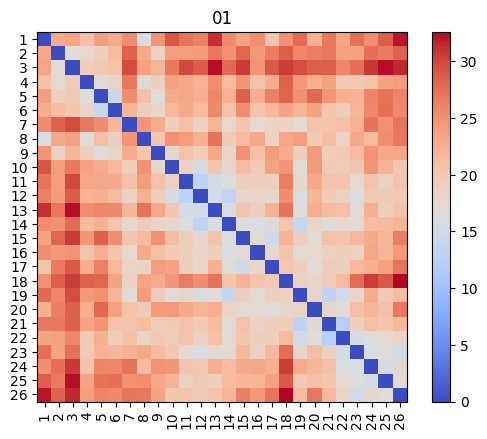

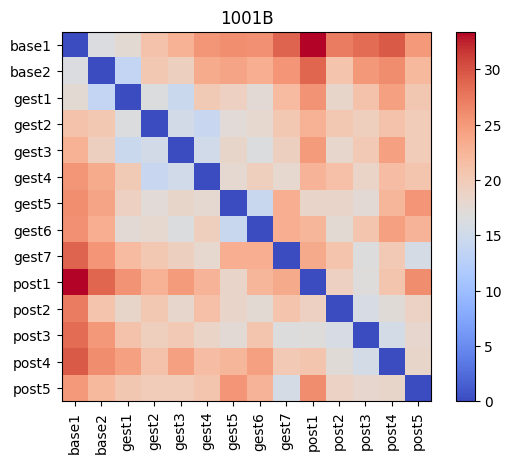

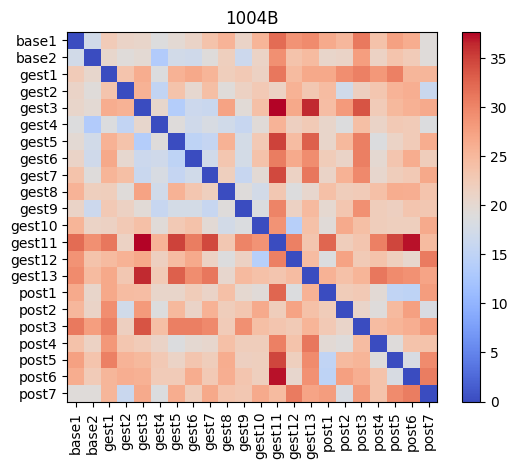

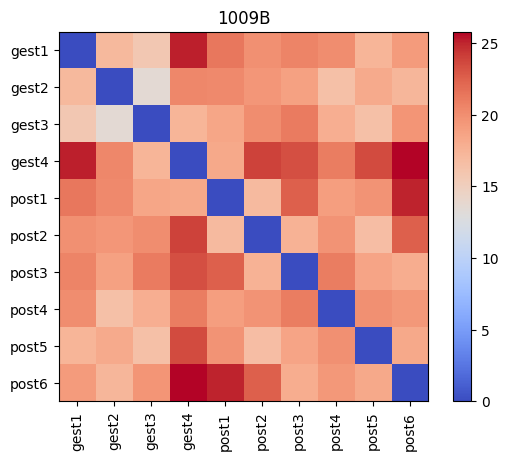

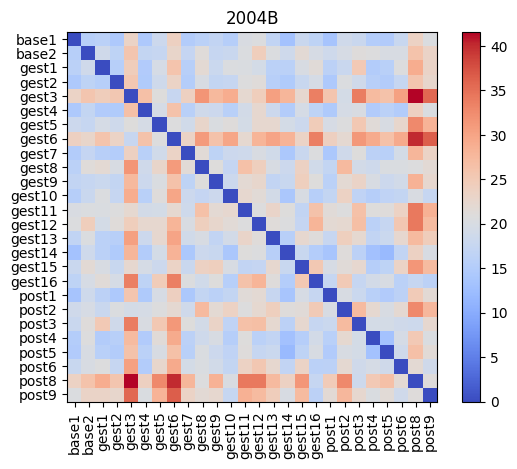

In [10]:
subj_dists_block = putils.get_diag_blocks_by_size(
    dists, [len(meshes) for meshes in meshes.values()]
)

for (subj, session_meshes), dists_subj in zip(meshes.items(), subj_dists_block):
    fig, ax = plt.subplots()

    im = ax.imshow(dists_subj, cmap="coolwarm")

    plt.colorbar(im)

    ticks = range(len(session_meshes))
    ticks_labels = session_meshes.keys()
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks_labels, rotation=90)

    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks_labels)

    ax.set_title(subj)

(np.float64(11.854543348333554), np.float64(158.8878278625366))

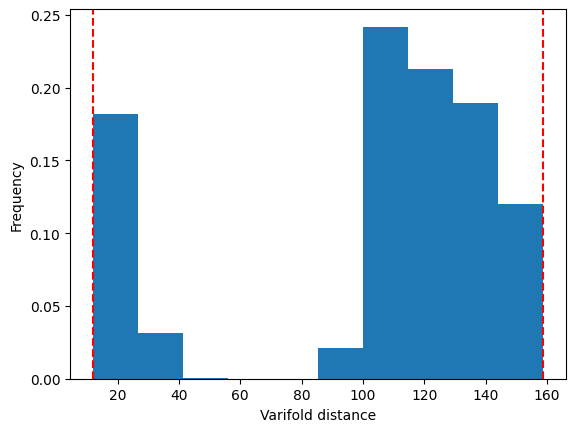

In [11]:
_, ax = plt.subplots()

dists_ = putils.sym_to_triu_vec(dists)
ax.hist(
    dists_,
    weights=1 / len(dists_) * np.ones_like(dists_),
)
ax.set_xlabel("Varifold distance")
ax.set_ylabel("Frequency")

min_dist, max_dist = np.amin(dists_), np.amax(dists_)
ax.axvline(min_dist, color="red", linestyle="--")
ax.axvline(max_dist, color="red", linestyle="--")

min_dist, max_dist

## Further reading

* [Varifold distances for different derivatives](./varifold_pairwise_distances_derivative.ipynb)